## Plot inter-basin transports from OTM solution and OTM air-sea flux

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import xarray as xr
import math
import numpy as np
from scipy.interpolate import griddata
import pandas as pd

In [2]:
# Load OTM result

OTMrun='true'
remap_2D = 'true'

carbon_preflux = True

yr_init=1992

Opt_result = xr.open_mfdataset(OTMrun+'_transports.nc')

Basins = Opt_result.Basins
tree_depth=int(math.log2(Opt_result.tree_depth))

month_init_early=(Opt_result.init_early-yr_init)*12
month_init_late=(Opt_result.init_late-yr_init)*12
Early_period = (np.array([month_init_early,month_init_early+Opt_result.dyrs*12]))
Late_period = (np.array([month_init_late,month_init_late+Opt_result.dyrs*12]))

dt = Opt_result.dt.values
dyrs = Opt_result.dyrs.astype('float64')

In [3]:
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients

# Establish basic constants 
yr2sec = 365.25*24*60*60
Cp=4000
rho=1029
S0=35

In [4]:
## Load BSP data

ECCO_BSP_data = xr.open_mfdataset(('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/tree_depth_6_BSP_ECCO/9_Basins_fluxerr_6/BSP_ECCO_monthly_*'))
    
## Early Period
Part_early = ECCO_BSP_data.Partitions_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ECCO_BSP_data.S_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ECCO_BSP_data.T_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
C_early = ECCO_BSP_data.C_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')                                 
V_early = ECCO_BSP_data.V_sum_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ECCO_BSP_data.A_sum_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
# Asection_early = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ECCO_BSP_data.Partitions_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ECCO_BSP_data.S_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ECCO_BSP_data.T_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
C_late = ECCO_BSP_data.C_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
V_late = ECCO_BSP_data.V_sum_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ECCO_BSP_data.A_sum_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
# Asection_late = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = ECCO_BSP_data.Basin.values

ECCO_time = xr.open_mfdataset('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/ECCO-Darwin/ECCO_time.nc')
ECCO_dt=(np.hstack([ECCO_time.ECCO_time[0].values,np.diff(ECCO_time.ECCO_time)])).reshape(1,323,1)
ECCO_dt=ECCO_dt[:,0:ECCO_BSP_data.Time.size,:]

In [5]:
# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
C_1 = C_early.values.flatten()
C_2 = C_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

if carbon_preflux:
    
    dC_Cflux = Opt_result.dC_Cflux
    dC_Cflux[np.isnan(dC_Cflux)] = 0
    dC_Cflux[~np.isfinite(dC_Cflux)] = 0
    
    C_1 = C_early.values.flatten() + dC_Cflux

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0
C_1[np.isnan(C_1)] = 0
C_2[np.isnan(C_2)] = 0

In [6]:
# Array defining the connection between the 9 basins;
# 1 = connected (sign convention: North = +, East = +), 0 = disconnected
d_ij = np.zeros((Basins.size,Basins.size))


d_ij[0,:] = [1, -1, 0, 0, 0, 0, 0, -1, 0]
d_ij[1,:] = [1, 1, -1, 0, 0, 0, 0, 0, 0]
d_ij[2,:] = [0, 1, 1, -1, 0, 0, 0, 0, 0]
d_ij[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, -1]
d_ij[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, -1]
d_ij[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, -1]
d_ij[6,:] = [0, 0, 0, 0, -1, -1, 1, 1, 0]
d_ij[7,:] = [1, 0, 0, 0, 0, 0, -1, 1, 0]
d_ij[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

d = {Basins[0]: d_ij.T[0,:],\
    Basins[1]: d_ij.T[1,:],\
    Basins[2]: d_ij.T[2,:],\
    Basins[3]: d_ij.T[3,:],\
    Basins[4]: d_ij.T[4,:],\
    Basins[5]: d_ij.T[5,:],\
    Basins[6]: d_ij.T[6,:],\
    Basins[7]: d_ij.T[7,:],\
    Basins[8]: d_ij.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table

,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
Subtropical N. Atlantic,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0
Indian,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
Eq. Pacific,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0,0.0
N. Pacific,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
Southern Ocean,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [7]:
g_ij = Opt_result.gij.values

section_trans = np.zeros((Vol_1.size,Vol_1.size))

for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = g_ij[i,j]/(dt*10**6)*d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])] # Sv

int_section_trans = np.zeros((Basins.size, Basins.size))
int_section_trans_C = np.zeros((Basins.size, Basins.size))
for i in (range(Basins.size)):
    for j in range(Basins.size):
        int_section_trans[i,j] = np.nansum(section_trans[V_early.shape[1]*i:(V_early.shape[1]*(i+1)),V_early.shape[1]*j:(V_early.shape[1]*(j+1))])

section_trans_temp = np.zeros((Vol_1.size, Basins.size))
section_trans_C_temp = np.zeros((Vol_1.size, Basins.size))
for j in range(Basins.size):
    section_trans_temp[:,j] = np.nansum(section_trans[:,V_early.shape[1]*j:(V_early.shape[1]*(j+1))],axis=-1)

In [8]:
basin_connex = np.array([[0,1],
                [1,2],
                [2,3],
                [3,8],
                [4,8],
                [4,6],
                [5,8],
                [6,5],
                [7,6],
                [0,7]]).astype(int)


T_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
S_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
C_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
section_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))

for i in range(int(np.size(basin_connex)/2)):
    T_joined[i,:] = np.concatenate([T_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],T_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    S_joined[i,:] = np.concatenate([S_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],S_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    C_joined[i,:] = np.concatenate([C_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],C_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    section_joined[i,:] = np.concatenate([section_trans_temp[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1)),basin_connex[i][1]],\
        section_trans_temp[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1)),basin_connex[i][0]]])
    


In [9]:
C_trans = C_joined*section_joined*10**6*yr2sec/(10**18/12) # PgC/yr
CF_section_tot = np.nansum(C_trans, axis=-1)
CF_section_tot

array([-0.65339641, -0.6009174 , -0.49384532, -0.36644618, -4.55286522,
       -4.69545265,  5.27645543,  5.24807622, -0.14517347,  0.36659783])

In [10]:
# Load remapped data

OTM_remapped=xr.open_mfdataset(OTMrun+'_remapped.nc')

if remap_2D:
    OTM_remapped=xr.open_mfdataset(OTMrun+'_remapped_2D.nc')


In [11]:
OTM_remapped

<xarray.Dataset>
Dimensions:            (i: 270, j: 270, face: 13, tree_depth: 64)
Coordinates: (12/22)
  * i                  (i) int32 0 1 2 3 4 5 6 7 ... 263 264 265 266 267 268 269
  * j                  (j) int32 0 1 2 3 4 5 6 7 ... 263 264 265 266 267 268 269
  * face               (face) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * tree_depth         (tree_depth) int64 0 1 2 3 4 5 6 ... 57 58 59 60 61 62 63
    k                  int32 ...
    Z                  float32 ...
    ...                 ...
    rA                 (face, j, i) float32 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
    hFacC              (face, j, i) float32 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
    maskC              (face, j, i) int8 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
    rLowC              (face, j, i) float32 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
    rSurfC             (face, j, i) float32 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
    lat                (face, j, i) float32 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
Data variables:
    dC_adj_remapped    (face, j, i) float32 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
    dC_Cflux_remapped  (face, j, i) float32 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
    dC_prior_remapped  (face, j, i) float32 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
    init_early         int32 ...
    init_late          int32 ...
    dyrs               int32 ...

In [15]:
## Calculate depth integrated fluxes

yr2sec=365.25*24*3600

dC_adj_remapped=OTM_remapped.dC_adj_remapped
dC_prior_remapped=OTM_remapped.dC_prior_remapped

if not remap_2D:

    dC_adj_int=(dC_adj_remapped*OTM_remapped.drF).sum('k')
    dC_prior_int=(dC_prior_remapped*OTM_remapped.drF).sum('k')

elif remap_2D:
        
    dC_adj_int = dC_adj_remapped
    dC_prior_int = dC_prior_remapped




lat=OTM_remapped.YC.values.flatten()
lon=OTM_remapped.XC.values.flatten()
lon[np.where(lon>180)]=lon[np.where(lon>180)]-360

(LAT,LON)=np.meshgrid(np.arange(-90,90),np.arange(-180.5,180.5))


dC_OTM_interp=griddata((lon,lat),(dC_prior_int+dC_adj_int).values.flatten(),(LON,LAT))

dC_OTM_flux=dC_OTM_interp/((OTM_remapped.init_late.values-OTM_remapped.init_early.values)*10**3) # mol-C/m^2/yr


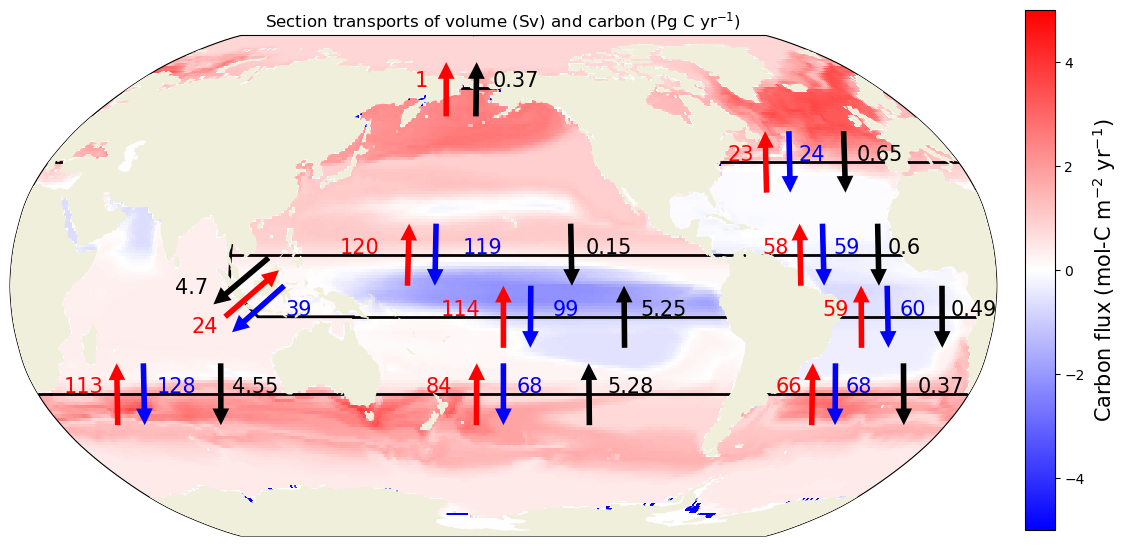

In [16]:
# Plot air sea carbon fluxes with carbon and volume transports


fig  = plt.figure(1, figsize = (15, 6.5))
gs = gridspec.GridSpec(1,1)
gs.update(wspace = 0.4, hspace=0)
fs = 15

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=-160))
minv, maxv = 0,8

ax1.stock_img()
#ax1.coastlines(zorder=101)

## SECTIONS
# Pacific Sector
ax1.plot([145,300],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,300],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([100,280],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([180,200],[65,65], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Indian Sector
ax1.plot([25,145],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,110,100,100],[-10,-10,0,20], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Atlantic Sector
ax1.plot([300,360],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([300,360],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

ax1.pcolormesh(LON, LAT, dC_OTM_flux, transform = ccrs.PlateCarree(), vmin=-5, vmax=5, cmap=plt.cm.bwr)
ax1.add_feature(cfeature.LAND, zorder=100)
plt.title('Section transports of volume (Sv) and carbon (Pg C yr$^{-1}$)')
cax = fig.add_axes([0.86, 0.12, 0.02, 0.8])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(-5, 5)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Carbon flux (mol-C m$^{-2}$ yr$^{-1}$)',fontsize=fs)

## S PAC <> SO

ax1.annotate('', xy=(190,-25), xytext=(189, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[5,-1]))), xy=(205,-25), xytext=(205, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(200,-45), xytext=(200, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none'), zorder=102)

ax1.annotate(int(np.round(int_section_trans[-1,5])), xy=(170,-25), xytext=(170, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

if CF_section_tot[6]>0:
        ax1.annotate('', xy=(232,-25), xytext=(235, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[6]).round(2)), xy=(240,-25), xytext=(240, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(235,-45), xytext=(232, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[6]).round(2)), xy=(240,-25), xytext=(240, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)


## EQ PAC <> S PAC

ax1.annotate('', xy=(200,0), xytext=(200, -20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[6,5]))), xy=(218,-9.5), xytext=(218, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(210,-20), xytext=(210, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none'), zorder=102)

ax1.annotate(np.round(int(int_section_trans[5,6])), xy=(177,-9.5), xytext=(177, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

if CF_section_tot[7]>0:

        ax1.annotate('', xy=(244,0), xytext=(245, -20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[7]).round(2)), xy=(250,-9.5), xytext=(250, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(245,-20), xytext=(244, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[7]).round(2)), xy=(250,-9.5), xytext=(250, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)


## EQ PAC <> N PAC

ax1.annotate('', xy=(165,20), xytext=(165, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[7,6]))), xy=(185,10.5), xytext=(185, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(175,0), xytext=(175, 20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[6,7]))), xy=(140,10.5), xytext=(140, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

if CF_section_tot[8]>0:


        ax1.annotate('', xy=(225,20), xytext=(225, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[8]).round(2)), xy=(230,10.5), xytext=(230, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(225,0), xytext=(225, 20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[8]).round(2)), xy=(230,10.5), xytext=(230, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)


## IND <> SO

ax1.annotate('', xy=(55,-25), xytext=(43, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[4,-1]))), xy=(66, -34.5), xytext=(66, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(54,-45), xytext=(65, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none'), zorder=102)

ax1.annotate(int(np.round(int_section_trans[-1,4])), xy=(30,-25), xytext=(30, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

if CF_section_tot[4]>0:
        ax1.annotate('', xy=(85,-45), xytext=(94, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)
        ax1.annotate(abs((CF_section_tot[4]).round(2)), xy=(95,-34.5), xytext=(95, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(85,-45), xytext=(94, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[4]).round(2)), xy=(95,-34.5), xytext=(95, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)


## EQ PAC <> IND

ax1.annotate('', xy=(118, 5), xytext=(98,-10),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[6,4]))), xy=(75,-9.5), xytext=(120, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(100, -15), xytext=(120,0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none'), zorder=102)

ax1.annotate(int(np.round(int_section_trans[4,6])), xy=(85,-15), xytext=(85, -15), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

if CF_section_tot[5]>0:
        ax1.annotate('', xy=(115, 7.5), xytext=(95,-7.5),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[5]).round(2)), xy=(75,-9.5), xytext=(120, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(94, -6), xytext=(114,9),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[5]).round(2)), xy=(80,-2.5), xytext=(80, -2.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)


## S ATL <> SO

ax1.annotate('', xy=(316,-25), xytext=(325.5, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[3,-1]))), xy=(332,-34.5), xytext=(332, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(335,-45), xytext=(324.5, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none'), zorder=102)

ax1.annotate(int(np.round(int_section_trans[-1,3])), xy=(305,-34.5), xytext=(305, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)


if CF_section_tot[3]>0:

        ax1.annotate('', xy=(350,-25), xytext=(3, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[3]).round(2)), xy=(0, -34.5), xytext=(0, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(3,-45), xytext=(350, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[3]).round(2)), xy=(0, -34.5), xytext=(0, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)


## EQ ATL <> S ATL

ax1.annotate('', xy=(330.5,0), xytext=(333, -20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[2,3]))), xy=(345,-9.5), xytext=(345, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(343,-20), xytext=(340, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none'), zorder=102)

ax1.annotate(int(np.round(int_section_trans[3,2])), xy=(317,-9.5), xytext=(317, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)


if CF_section_tot[2]>0:

        ax1.annotate('', xy=(0,0), xytext=(3, -20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[2]).round(2)), xy=(4,-9.5), xytext=(4, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(3,-20), xytext=(0, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[2]).round(2)), xy=(4,-9.5), xytext=(4, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)




## EQ ATL <> ST ATL

ax1.annotate('', xy=(310,20), xytext=(308.5, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[1,2]))), xy=(321,10.5), xytext=(321, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(317,0), xytext=(318.5, 20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[2,1]))), xy=(295,10.5), xytext=(295, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)


if CF_section_tot[1]>0:

        ax1.annotate('', xy=(339,20), xytext=(337, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[1]).round(2)), xy=(341,10.5), xytext=(341, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(337,0), xytext=(339, 20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[1]).round(2)), xy=(341,10.5), xytext=(341, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)



## ST ATL <> POL ATL

ax1.annotate('', xy=(310,50), xytext=(300, 30),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[0,1]))), xy=(317,40.5), xytext=(317, 40.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(309,30), xytext=(320, 50),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[1,0]))), xy=(289,40.5), xytext=(289, 40.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)


if CF_section_tot[0]>0:

        ax1.annotate('', xy=(343,50), xytext=(330, 30),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)
        ax1.annotate(abs((CF_section_tot[0]).round(2)), xy=(340,40.5), xytext=(340, 40.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(330,30), xytext=(343, 50),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[0]).round(2)), xy=(340,40.5), xytext=(340, 40.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
        
## Bering Strait

ax1.annotate('', xy=(169,75), xytext=(175, 55),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none'), zorder=102)

#ax1.annotate(abs(int(np.round(int_section_trans[0,7]))), xy=(195,65.5), xytext=(195, 65.5), \
#        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

#ax1.annotate('', xy=(190,55), xytext=(190, 75),
#        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
#        arrowprops=dict(facecolor='blue', ec='none'), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[7,0]))), xy=(157,65.5), xytext=(157, 65.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

if CF_section_tot[9]>0:

        ax1.annotate('', xy=(185.5,75), xytext=(188, 55),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)
        ax1.annotate(abs((CF_section_tot[9]).round(2)), xy=(195,65.5), xytext=(195, 65.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(188,55), xytext=(185.5, 75),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none'), zorder=102)

        ax1.annotate(abs((CF_section_tot[9]).round(2)), xy=(195,65.5), xytext=(195, 65.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)



#plt.savefig(OTMrun+'_basin_transport.png', bbox_inches='tight', dpi=300, transparent=True)

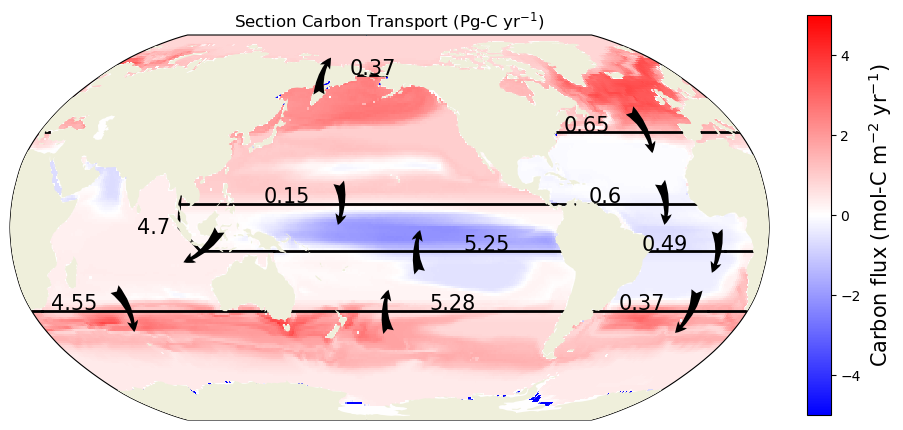

In [17]:
# Plot air sea carbon fluxes with carbon transports

fig  = plt.figure(1, figsize = (12, 5))
gs = gridspec.GridSpec(1,1)
gs.update(wspace = 0.4, hspace=0)
fs = 15

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=-160))
minv, maxv = 0,8

ax1.stock_img()
#ax1.coastlines(zorder=101)

## SECTIONS
# Pacific Sector
ax1.plot([145,300],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,300],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([100,280],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([180,200],[65,65], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Indian Sector
ax1.plot([25,145],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,110,100,100],[-10,-10,0,20], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Atlantic Sector
ax1.plot([300,360],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([300,360],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

ax1.pcolormesh(LON, LAT, dC_OTM_flux, transform = ccrs.PlateCarree(), vmin=-5, vmax=5, cmap=plt.cm.bwr)
ax1.add_feature(cfeature.LAND, zorder=100)
plt.title('Section transports of volume (Sv) and carbon (Pg C yr$^{-1}$)',fontsize=fs)
cax = fig.add_axes([0.86, 0.12, 0.02, 0.8])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(-5, 5)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Carbon flux (mol-C m$^{-2}$ yr$^{-1}$)',fontsize=fs)


## S PAC <> SO

if CF_section_tot[6]>0:
        ax1.annotate('', xy=(200,-25), xytext=(200, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[6]).round(2)), xy=(200,-25), xytext=(220, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(210,-45), xytext=(210, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[6]).round(2)), xy=(175,-25), xytext=(175, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## EQ PAC <> S PAC
if CF_section_tot[7]>0:

        ax1.annotate('', xy=(215,0), xytext=(215, -20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[7]).round(2)), xy=(235,-9.5), xytext=(235, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(225,-20), xytext=(225, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[7]).round(2)), xy=(190,-9.5), xytext=(190, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## EQ PAC <> N PAC
if CF_section_tot[8]>0:


        ax1.annotate('', xy=(165,20), xytext=(165, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[8]).round(2)), xy=(185,10.5), xytext=(185, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(175,0), xytext=(175, 20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[8]).round(2)), xy=(140,10.5), xytext=(140, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## IND <> SO
if CF_section_tot[4]>0:
        ax1.annotate('', xy=(55,-25), xytext=(55, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
        ax1.annotate(abs((CF_section_tot[4]).round(2)), xy=(75,-25), xytext=(75, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(65,-45), xytext=(65, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[4]).round(2)), xy=(30,-25), xytext=(30, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## EQ PAC <> IND
if CF_section_tot[5]>0:
        ax1.annotate('', xy=(115, 7.5), xytext=(95,-7.5),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[5]).round(2)), xy=(75,-9.5), xytext=(120, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(100, -15), xytext=(120,0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[5]).round(2)), xy=(80,-2.5), xytext=(80, -2.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)


## S ATL <> SO
if CF_section_tot[3]>0:

        ax1.annotate('', xy=(340,-25), xytext=(340, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[3]).round(2)), xy=(360,-25), xytext=(360, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(350,-45), xytext=(350, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[3]).round(2)), xy=(315,-25), xytext=(315, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## EQ ATL <> S ATL
if CF_section_tot[2]>0:

        ax1.annotate('', xy=(345,0), xytext=(345, -20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[2]).round(2)), xy=(2.5,-9.5), xytext=(2.5, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(355,-20), xytext=(355, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[2]).round(2)), xy=(320,-9.5), xytext=(320, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## EQ ATL <> ST ATL
if CF_section_tot[1]>0:

        ax1.annotate('', xy=(320,20), xytext=(320, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[1]).round(2)), xy=(335,10.5), xytext=(335, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(330,0), xytext=(330, 20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[1]).round(2)), xy=(295,10.5), xytext=(295, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## ST ATL <> POL ATL
if CF_section_tot[0]>0:

        ax1.annotate('', xy=(320,50), xytext=(320, 30),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
        ax1.annotate(abs((CF_section_tot[0]).round(2)), xy=(335,40.5), xytext=(335, 40.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(330,30), xytext=(330, 50),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[0]).round(2)), xy=(290,40.5), xytext=(290, 40.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

ax1.set_title('Section Carbon Transport (Pg-C yr$^{-1}$)')

## Bering Strait
if CF_section_tot[9]>0:

        ax1.annotate('', xy=(160,75), xytext=(160, 55),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
        ax1.annotate(abs((CF_section_tot[9]).round(2)), xy=(175,65.5), xytext=(175, 65.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(170,55), xytext=(170, 75),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[9]).round(2)), xy=(140,65.5), xytext=(140, 65.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

plt.savefig(OTMrun+'_basin_transport.png', bbox_inches='tight', dpi=300, transparent=True)